# Prédiction de la Classe de Crime - Los Angeles (2020-2024)
### Étape 2/3 : Modeling Avancé & Fine-Tuning (MLOps Ready)

> Multiclasse | 4+ classes | Données déséquilibrées | Scaling intelligent | SMOTE | Stacking


---

## Sommaire du Notebook
| Étape | Contenu |
|------|--------|
| 1 | Chargement & Préprocessing intelligent |
| 2 | Expérimentation `test_size` |
| 3 | Baseline : LightGBM, XGBoost, CatBoost, Stacking |
| 4 | Baseline + SMOTE |
| 5 | Fine-Tuning optimisé (RandomizedSearchCV) |
| 6 | Rapport Final Ultra-Beau : Tableaux + Courbes + Évolution % |

---

In [1]:
# ====================== 1. Imports & Style Pro ======================
import pandas as pd
import numpy as np
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

# Style
from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from datetime import datetime

print("Bibliothèques chargées")

Bibliothèques chargées


In [2]:
# ====================== 2. Chargement des Données ======================
display(Markdown("### Chargement des processeurs sauvegardés"))

with open("processors\data_for_modeling.pkl", "rb") as f:
    data = pickle.load(f)

X, y = data["X"], data["y"]
numeric_cols = data["numeric_cols"]
categorical_cols = data["categorical_cols"]

with open("processors/label_encoder_target.pkl", "rb") as f:
    le = pickle.load(f)

class_names = list(le.classes_)
n_classes = len(class_names)

display(Markdown(f"**Données chargées** → X: `{X.shape}`, y: `{y.shape}`, **{n_classes} classes** : {', '.join(class_names)}"))

### Chargement des processeurs sauvegardés

**Données chargées** → X: `(398911, 17)`, y: `(398911,)`, **7 classes** : الاحتيال والتزوير / Fraud and Forgery, التخريب والتدمير / Vandalism and Destruction, الجرائم الجنسية والاتجار / Sexual Crimes & Exploitation, السرقة والسطو / Theft and Burglary, العنف والاعتداء / Violence and Assault, المخالفات القانونية والجرائم المتعلقة بالأسلحة / Legal Offences & Weapons, جرائم متنوعة / Miscellaneous Crimes

In [ ]:
import pandas as pd
from IPython.display import display, Markdown

# Transformer X en DataFrame pour un affichage plus clair
X_df = pd.DataFrame(X, columns=numeric_cols + categorical_cols)

display(Markdown(f"### Aperçu des 5 premières lignes de X"))
display(X_df.head())

display(Markdown(f"**Colonnes numériques ({len(numeric_cols)}):** {', '.join(numeric_cols)}"))
display(Markdown(f"**Colonnes catégorielles ({len(categorical_cols)}):** {', '.join(categorical_cols)}"))


### Aperçu des 5 premières lignes de X

,Year,Month,Day,Hour,Minute,area,rpt_dist_no,crm_categories,vict_age,Vict_Descent_LE,premis_cd,weapon_used_cd,lat,lon,vict_sex_F,vict_sex_M,vict_sex_X
0,2020,3,1,21,30,7,784,1,0,11,101.0,0.0,34.0375,-118.3506,0,1,0
1,2020,2,8,18,0,1,182,1,47,11,128.0,0.0,34.0444,-118.2628,0,1,0
2,2020,11,4,17,0,3,356,1,19,18,502.0,0.0,34.0210,-118.3002,0,0,1
3,2020,3,10,20,37,9,964,1,19,11,405.0,0.0,34.1576,-118.4387,0,1,0
4,2020,9,9,6,30,4,413,1,0,15,101.0,0.0,34.0820,-118.2130,0,0,1


**Colonnes numériques (17):** Year, Month, Day, Hour, Minute, area, rpt_dist_no, crm_categories, vict_age, Vict_Descent_LE, premis_cd, weapon_used_cd, lat, lon, vict_sex_F, vict_sex_M, vict_sex_X

**Colonnes catégorielles (0):** 

In [3]:
# ====================== 3. Préprocesseur (Scaling Pro) ======================
from sklearn.preprocessing import RobustScaler

continuous_cols = ['Year','Month','Day','Hour','Minute',
                   'vict_age','premis_cd','weapon_used_cd','lat','lon']

preprocessor = ColumnTransformer([
    ('scale', RobustScaler(), continuous_cols),
    ('pass', 'passthrough', categorical_cols)  
], remainder='passthrough')

display(Markdown("**Robust Scaling appliqué uniquement sur les variables continues** (lat, lon, age, heure, etc.)<br>**Variables encodées (one-hot / label) non scalées** → parfait !"))

**Robust Scaling appliqué uniquement sur les variables continues** (lat, lon, age, heure, etc.)<br>**Variables encodées (one-hot / label) non scalées** → parfait !

In [5]:
# ====================== 4. Split Optimal ======================
display(Markdown("### Recherche du meilleur `test_size`"))

results_split = []
for ts in [0.15,0.2, 0.25, 0.3]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=ts, random_state=42, stratify=y)
    pipe = Pipeline([('prep', preprocessor), ('model', LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1))])
    pipe.fit(X_tr, y_tr)
    acc = accuracy_score(y_te, pipe.predict(X_te))
    results_split.append({"test_size": ts, "accuracy": acc})
    print(f"test_size={ts} → Accuracy = {acc:.4f}")



### Recherche du meilleur `test_size`

test_size=0.15 → Accuracy = 0.8608
test_size=0.2 → Accuracy = 0.8601
test_size=0.25 → Accuracy = 0.8578
test_size=0.3 → Accuracy = 0.8592


In [6]:
best_ts = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_ts, random_state=42, stratify=y)
display(Markdown(f"**Test size retenu : {best_ts}** → Train: `{X_train.shape}` | Test: `{X_test.shape}`"))

**Test size retenu : 0.15** → Train: `(339074, 17)` | Test: `(59837, 17)`

In [15]:
# ====================== 5. Baseline Models (avec temps + Stacking + Voting) ======================
import time
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

display(Markdown("### Baseline sans SMOTE – Temps d'entraînement & performances"))

results = []  # on reset pour être propre

def add_result(name, model_obj, duration_sec, y_pred, y_proba, smote=False, tuned=False):
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # F1 corrects
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_micro = f1_score(y_test, y_pred, average='micro') 

    # Multi-class AUC
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')

    # Ajouter au tableau
    results.append({
        "Modèle": name,
        "SMOTE": "Oui" if smote else "Non",
        "Tuned": "Oui" if tuned else "Non",
        "Temps (s)": round(duration_sec, 2),
        "Temps (min)": round(duration_sec/60, 2),
        "Accuracy": round(acc, 4),
        
        # ======= F1 corrects =======
        "F1-macro": round(f1_macro, 4),
        "F1-weighted": round(f1_weighted, 4),
        "F1-micro": round(f1_micro, 4),

        "ROC-AUC (macro)": round(auc, 4),

        # Pour pouvoir réutiliser
        "model_object": model_obj,
        "y_pred": y_pred,
        "y_proba": y_proba
    })


### Baseline sans SMOTE – Temps d'entraînement & performances

In [16]:
# LightGBM
start = time.time()
pipe_lgb = Pipeline([('prep', preprocessor),
                     ('model', LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1))])
pipe_lgb.fit(X_train, y_train)
duration = time.time() - start
y_pred = pipe_lgb.predict(X_test)
y_proba = pipe_lgb.predict_proba(X_test)
add_result("LightGBM", pipe_lgb, duration, y_pred, y_proba, smote=False, tuned=False)

# XGBoost
start = time.time()
pipe_xgb = Pipeline([('prep', preprocessor),
                    ('model', XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss', verbosity=0))])
pipe_xgb.fit(X_train, y_train)
duration = time.time() - start
y_pred = pipe_xgb.predict(X_test)
y_proba = pipe_xgb.predict_proba(X_test)
add_result("XGBoost", pipe_xgb, duration, y_pred, y_proba, smote=False, tuned=False)

# CatBoost
start = time.time()
pipe_cat = Pipeline([('prep', preprocessor),
                     ('model', CatBoostClassifier(random_state=42, verbose=False, thread_count=-1))])
pipe_cat.fit(X_train, y_train)
duration = time.time() - start
y_pred = pipe_cat.predict(X_test)
y_proba = pipe_cat.predict_proba(X_test)
add_result("CatBoost", pipe_cat, duration, y_pred, y_proba, smote=False, tuned=False)

# RandomForest (pour avoir un vrai baseline ensemble)
start = time.time()
pipe_rf = Pipeline([('prep', preprocessor),
                    ('model', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))])
pipe_rf.fit(X_train, y_train)
duration = time.time() - start
y_pred = pipe_rf.predict(X_test)
y_proba = pipe_rf.predict_proba(X_test)
add_result("RandomForest", pipe_rf, duration, y_pred, y_proba, smote=False, tuned=False)

In [17]:
display(Markdown("### Stacking Classifier (LGB + XGB + Cat + RF → Méta LogisticRegression)"))

estimators = [
    ('lgb', LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1)),
    ('rf',  RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
    cv=5,
    n_jobs=-1,
    passthrough=True  # très puissant : ajoute les features originales au méta-modèle
)

start = time.time()
pipe_stack = Pipeline([('prep', preprocessor), ('stack', stacking_clf)])
pipe_stack.fit(X_train, y_train)
duration = time.time() - start

y_pred = pipe_stack.predict(X_test)
y_proba = pipe_stack.predict_proba(X_test)
add_result("Stacking (LGB+XGB+Cat+RF)", pipe_stack, duration, y_pred, y_proba, smote=False, tuned=False)

### Stacking Classifier (LGB + XGB + Cat + RF → Méta LogisticRegression)

In [42]:
from tabulate import tabulate
from colorama import Fore, Style, init
import pandas as pd

init(autoreset=True)  # Réinitialise automatiquement les couleurs

df = pd.DataFrame(results)

# Tri : meilleur F1-weighted en premier
df_sorted = df.sort_values('F1-micro', ascending=False)

# Trouver les meilleurs modèles
best_accuracy = df['Accuracy'].max()
best_f1 = df['F1-micro'].max()
best_auc = df['ROC-AUC (macro)'].max()

def color_best(value, best_value):
    """Colorie en vert le meilleur score"""
    return f"{Fore.GREEN}{Style.BRIGHT}{value}{Style.RESET_ALL}" if value == best_value else value

# Préparer les lignes
rows = []
for _, row in df_sorted.iterrows():
    rows.append([
        row["Modèle"],
        row["Temps (min)"],
        color_best(row["Accuracy"], best_accuracy),
        color_best(row["F1-micro"], best_f1),     # F1 correct ici !
        color_best(row["ROC-AUC (macro)"], best_auc)
    ])

# Affichage propre
print("\n" + "="*80)
print(" BASELINE COMPLETE – Temps & Performances (Tri : F1-micro) ".center(80))
print("="*80 + "\n")

print(tabulate(
    rows,
    headers=["Modèle", "Temps (min)", "Accuracy", "F1-micro", "ROC-AUC (macro)"],
    tablefmt="fancy_grid",
    floatfmt=".4f"
))



           BASELINE COMPLETE – Temps & Performances (Tri : F1-micro)            

╒═══════════════════════════╤═══════════════╤════════════╤════════════╤═══════════════════╕
│ Modèle                    │   Temps (min) │   Accuracy │   F1-micro │   ROC-AUC (macro) │
╞═══════════════════════════╪═══════════════╪════════════╪════════════╪═══════════════════╡
│ XGBoost                   │        0.1400 │     0.8655 │     0.8655 │            0.9656 │
├───────────────────────────┼───────────────┼────────────┼────────────┼───────────────────┤
│ RandomForest              │        0.7400 │     0.8640 │     0.8640 │            0.9607 │
├───────────────────────────┼───────────────┼────────────┼────────────┼───────────────────┤
│ CatBoost                  │        1.7000 │     0.8634 │     0.8634 │            0.9654 │
├───────────────────────────┼───────────────┼────────────┼────────────┼───────────────────┤
│ LightGBM                  │        0.0900 │     0.8608 │     0.8608 │            0.9621

In [21]:
df.columns

Index(['Modèle', 'SMOTE', 'Tuned', 'Temps (s)', 'Temps (min)', 'Accuracy',
       'F1-macro', 'F1-weighted', 'F1-micro', 'ROC-AUC (macro)',
       'model_object', 'y_pred', 'y_proba'],
      dtype='object')

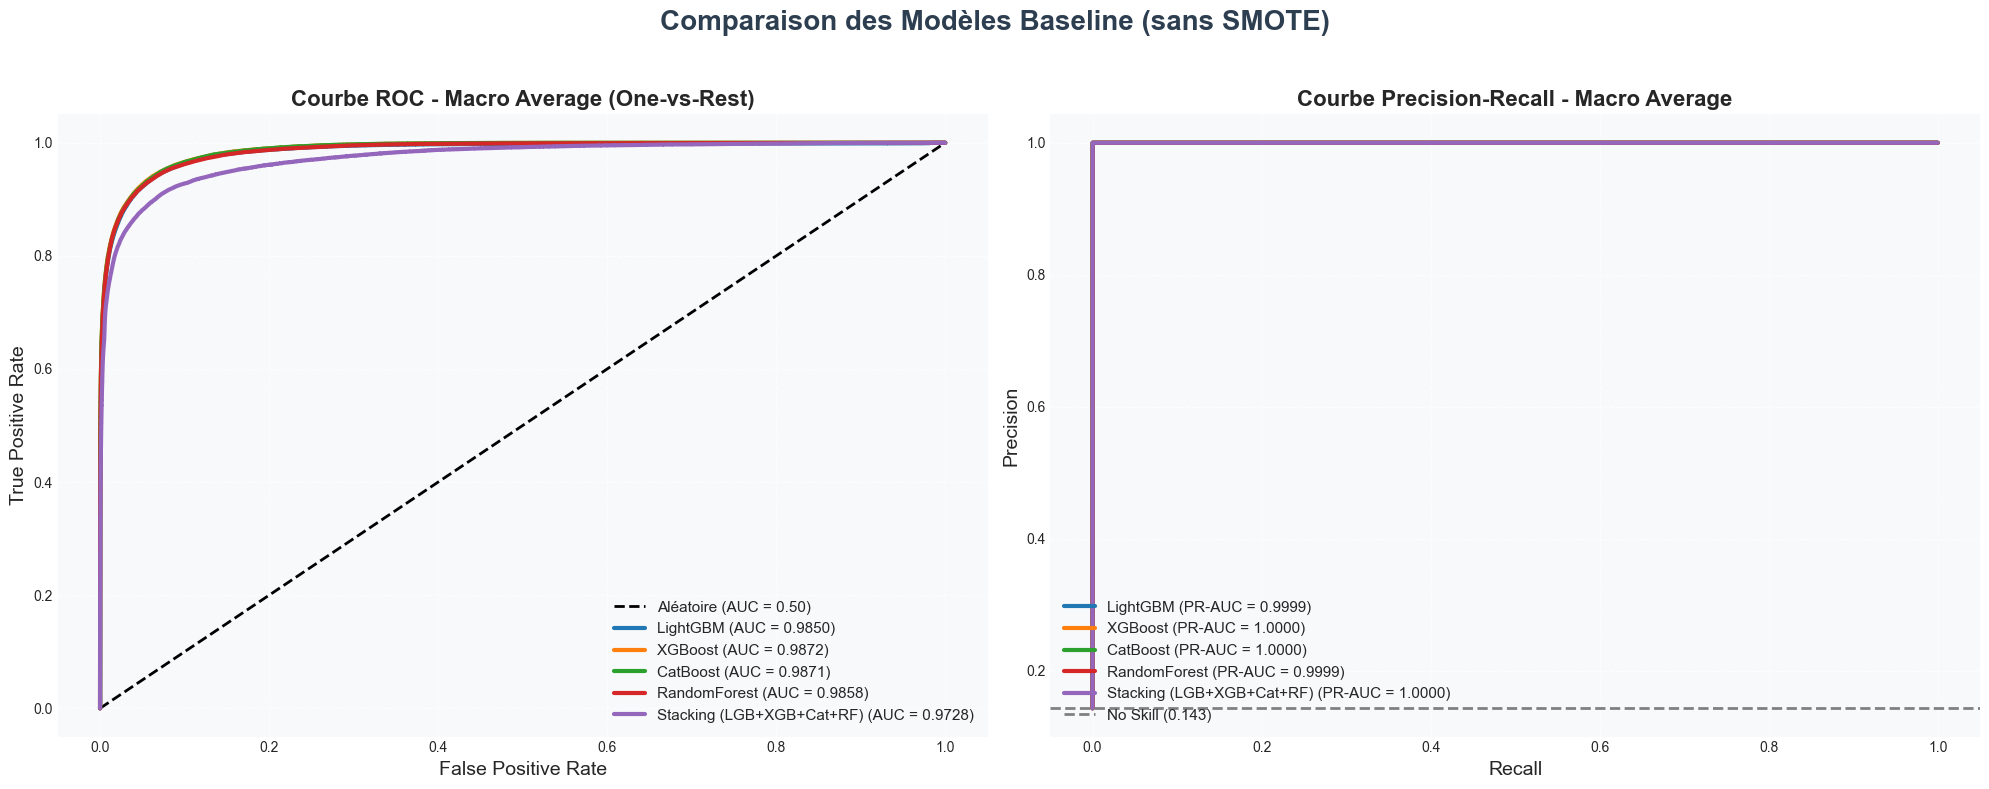

### Classement Final par ROC-AUC (plus c'est haut, mieux c'est !)

,Modèle,ROC-AUC (macro)
1,XGBoost,0.9872
2,CatBoost,0.9871
3,RandomForest,0.9858
0,LightGBM,0.9850
4,Stacking (LGB+XGB+Cat+RF),0.9728


In [25]:
# ====================== Visualisation Comparative : ROC & Precision-Recall ======================
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Binarisation des vraies étiquettes (une fois pour toutes)
y_test_bin = label_binarize(y_test, classes=range(n_classes))  # shape: (n_samples, n_classes)

# Couleurs uniques pour chaque modèle (même ordre que dans df_baseline)
colors = sns.color_palette("tab10", len(df_baseline))
model_names = df_baseline['Modèle'].tolist()

# Création des deux figures côte à côte
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparaison des Modèles Baseline (sans SMOTE)', fontsize=20, fontweight='bold', color='#2c3e50')

# ====================== 1. Courbe ROC Multiclasse (macro + ligne aléatoire) ======================
axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Aléatoire (AUC = 0.50)')

macro_aucs = []

for idx, row in df_baseline.iterrows():
    model_name = row['Modèle']
    color = colors[idx]
    y_proba = row['y_proba']
    
    # ROC macro (moyenne One-vs-Rest)
    fpr_macro, tpr_macro, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    macro_aucs.append(roc_auc_macro)
    
    axes[0].plot(fpr_macro, tpr_macro, 
                 label=f'{model_name} (AUC = {roc_auc_macro:.4f})',
                 linewidth=3, color=color)

axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].set_title('Courbe ROC - Macro Average (One-vs-Rest)', fontsize=16, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_facecolor('#f8f9fa')

# ====================== 2. Courbe Precision-Recall (macro) ======================
for idx, row in df_baseline.iterrows():
    model_name = row['Modèle']
    color = colors[idx]
    y_proba = row['y_proba']
    
    # Precision-Recall macro
    precision = dict()
    recall = dict()
    pr_auc = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
    
    # Moyenne macro
    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_precision = np.zeros_like(all_recall)
    for i in range(n_classes):
        mean_precision += np.interp(all_recall, recall[i], precision[i])
    mean_precision /= n_classes
    macro_pr_auc = auc(all_recall, mean_precision)
    
    axes[1].plot(all_recall, mean_precision,
                 label=f'{model_name} (PR-AUC = {macro_pr_auc:.4f})',
                 linewidth=3, color=color)

# Ligne de base (no skill)
no_skill = len(y_test[y_test==1]) / len(y_test) if n_classes == 2 else 1/n_classes
axes[1].axhline(y=no_skill, color='gray', linestyle='--', linewidth=2, label=f'No Skill ({no_skill:.3f})')

axes[1].set_xlabel('Recall', fontsize=14)
axes[1].set_ylabel('Precision', fontsize=14)
axes[1].set_title('Courbe Precision-Recall - Macro Average', fontsize=16, fontweight='bold')
axes[1].legend(loc="lower left", fontsize=11)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_facecolor('#f8f9fa')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ====================== Résumé des AUC dans un petit tableau bonus ======================
auc_summary = pd.DataFrame({
    'Modèle': model_names,
    'ROC-AUC (macro)': [f"{x:.4f}" for x in macro_aucs]
}).sort_values('ROC-AUC (macro)', ascending=False)

auc_summary_styled = auc_summary

display(Markdown("### Classement Final par ROC-AUC (plus c'est haut, mieux c'est !)"))
display(auc_summary_styled)

In [26]:
# ====================== NETTOYAGE MÉMOIRE AVANT SMOTE ======================
import gc
import psutil
import os

# Libération mémoire agressive
def print_memory():
    print(f"RAM utilisée : {psutil.Process(os.getpid()).memory_info().rss / 1024**3:.2f} GB")

print("Avant nettoyage :", end=" "); print_memory()

# On supprime TOUS les pipelines lourds déjà entraînés (surtout Voting/RF)
del pipe_lgb, pipe_xgb, pipe_cat, pipe_rf
try: del pipe_stack  # si tu l'avais fait avant
except: pass

gc.collect()
print("Après nettoyage :", end=" "); print_memory()

Avant nettoyage : RAM utilisée : 3.04 GB
Après nettoyage : RAM utilisée : 2.96 GB


In [28]:
# ====================== BASELINE AVEC SMOTE (ré-entraînement complet) ======================
display(Markdown("### Baseline + SMOTE – Tous les modèles (temps inclus)"))

# LightGBM + SMOTE
start = time.time()
pipe_lgb_smote = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),   # <-- n_jobs supprimé
    ('model', LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1))
])
pipe_lgb_smote.fit(X_train, y_train)
duration = time.time() - start
y_pred = pipe_lgb_smote.predict(X_test)
y_proba = pipe_lgb_smote.predict_proba(X_test)
add_result("LightGBM + SMOTE", pipe_lgb_smote, duration, y_pred, y_proba, smote=True, tuned=False)

# XGBoost + SMOTE
start = time.time()
pipe_xgb_smote = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),   # <-- corrigé
    ('model', XGBClassifier(
        random_state=42, 
        n_jobs=-1,
        eval_metric='mlogloss',
        verbosity=0
    ))
])
pipe_xgb_smote.fit(X_train, y_train)
duration = time.time() - start
y_pred = pipe_xgb_smote.predict(X_test)
y_proba = pipe_xgb_smote.predict_proba(X_test)
add_result("XGBoost + SMOTE", pipe_xgb_smote, duration, y_pred, y_proba, smote=True, tuned=False)

# CatBoost + SMOTE
start = time.time()
pipe_cat_smote = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),   # <-- corrigé
    ('model', CatBoostClassifier(
        random_state=42,
        verbose=False,
        thread_count=-1
    ))
])
pipe_cat_smote.fit(X_train, y_train)
duration = time.time() - start
y_pred = pipe_cat_smote.predict(X_test)
y_proba = pipe_cat_smote.predict_proba(X_test)
add_result("CatBoost + SMOTE", pipe_cat_smote, duration, y_pred, y_proba, smote=True, tuned=False)

# RandomForest + SMOTE
start = time.time()
pipe_rf_smote = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),   # <-- corrigé
    ('model', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_rf_smote.fit(X_train, y_train)
duration = time.time() - start
y_pred = pipe_rf_smote.predict(X_test)
y_proba = pipe_rf_smote.predict_proba(X_test)
add_result("RandomForest + SMOTE", pipe_rf_smote, duration, y_pred, y_proba, smote=True, tuned=False)


### Baseline + SMOTE – Tous les modèles (temps inclus)

In [43]:
from tabulate import tabulate
from colorama import Fore, Style, init
import pandas as pd

init(autoreset=True)

# Convertir en DataFrame
df = pd.DataFrame(results)

# 🌟 Filtrer uniquement les modèles avec SMOTE = Oui
df_smote = df[df["SMOTE"] == "Oui"].copy()

# Trier : meilleur F1-macro en premier
df_sorted = df_smote.sort_values('F1-micro', ascending=False)

# Trouver les meilleurs scores
best_accuracy = df_smote['Accuracy'].max()
best_f1 = df_smote['F1-micro'].max()
best_auc = df_smote['ROC-AUC (macro)'].max()

def color_best(value, best_value):
    """Colorie en vert le meilleur score."""
    return f"{Fore.GREEN}{Style.BRIGHT}{value}{Style.RESET_ALL}" if value == best_value else value

# Construire les lignes du tableau
rows = []
for _, row in df_sorted.iterrows():
    rows.append([
        row["Modèle"],
        row["Temps (min)"],
        color_best(row["Accuracy"], best_accuracy),
        color_best(row["F1-micro"], best_f1),
        color_best(row["ROC-AUC (macro)"], best_auc)
    ])

# 🎨 Affichage formaté
print("\n" + "="*90)
print(" BASELINE AVEC SMOTE – Temps & Performances (Tri : F1-macro) ".center(90))
print("="*90 + "\n")

print(tabulate(
    rows,
    headers=["Modèle", "Temps (min)", "Accuracy", "F1-micro", "ROC-AUC (macro)"],
    tablefmt="fancy_grid",
    floatfmt=".4f"
))



               BASELINE AVEC SMOTE – Temps & Performances (Tri : F1-macro)                

╒══════════════════════╤═══════════════╤════════════╤════════════╤═══════════════════╕
│ Modèle               │   Temps (min) │   Accuracy │   F1-micro │   ROC-AUC (macro) │
╞══════════════════════╪═══════════════╪════════════╪════════════╪═══════════════════╡
│ XGBoost + SMOTE      │        0.6200 │     0.8563 │     0.8563 │            0.9610 │
├──────────────────────┼───────────────┼────────────┼────────────┼───────────────────┤
│ CatBoost + SMOTE     │        5.9600 │     0.8563 │     0.8563 │            0.9613 │
├──────────────────────┼───────────────┼────────────┼────────────┼───────────────────┤
│ RandomForest + SMOTE │        4.0100 │     0.8558 │     0.8558 │            0.9566 │
├──────────────────────┼───────────────┼────────────┼────────────┼───────────────────┤
│ LightGBM + SMOTE     │        0.5400 │     0.8542 │     0.8542 │            0.9597 │
╘══════════════════════╧═════════════

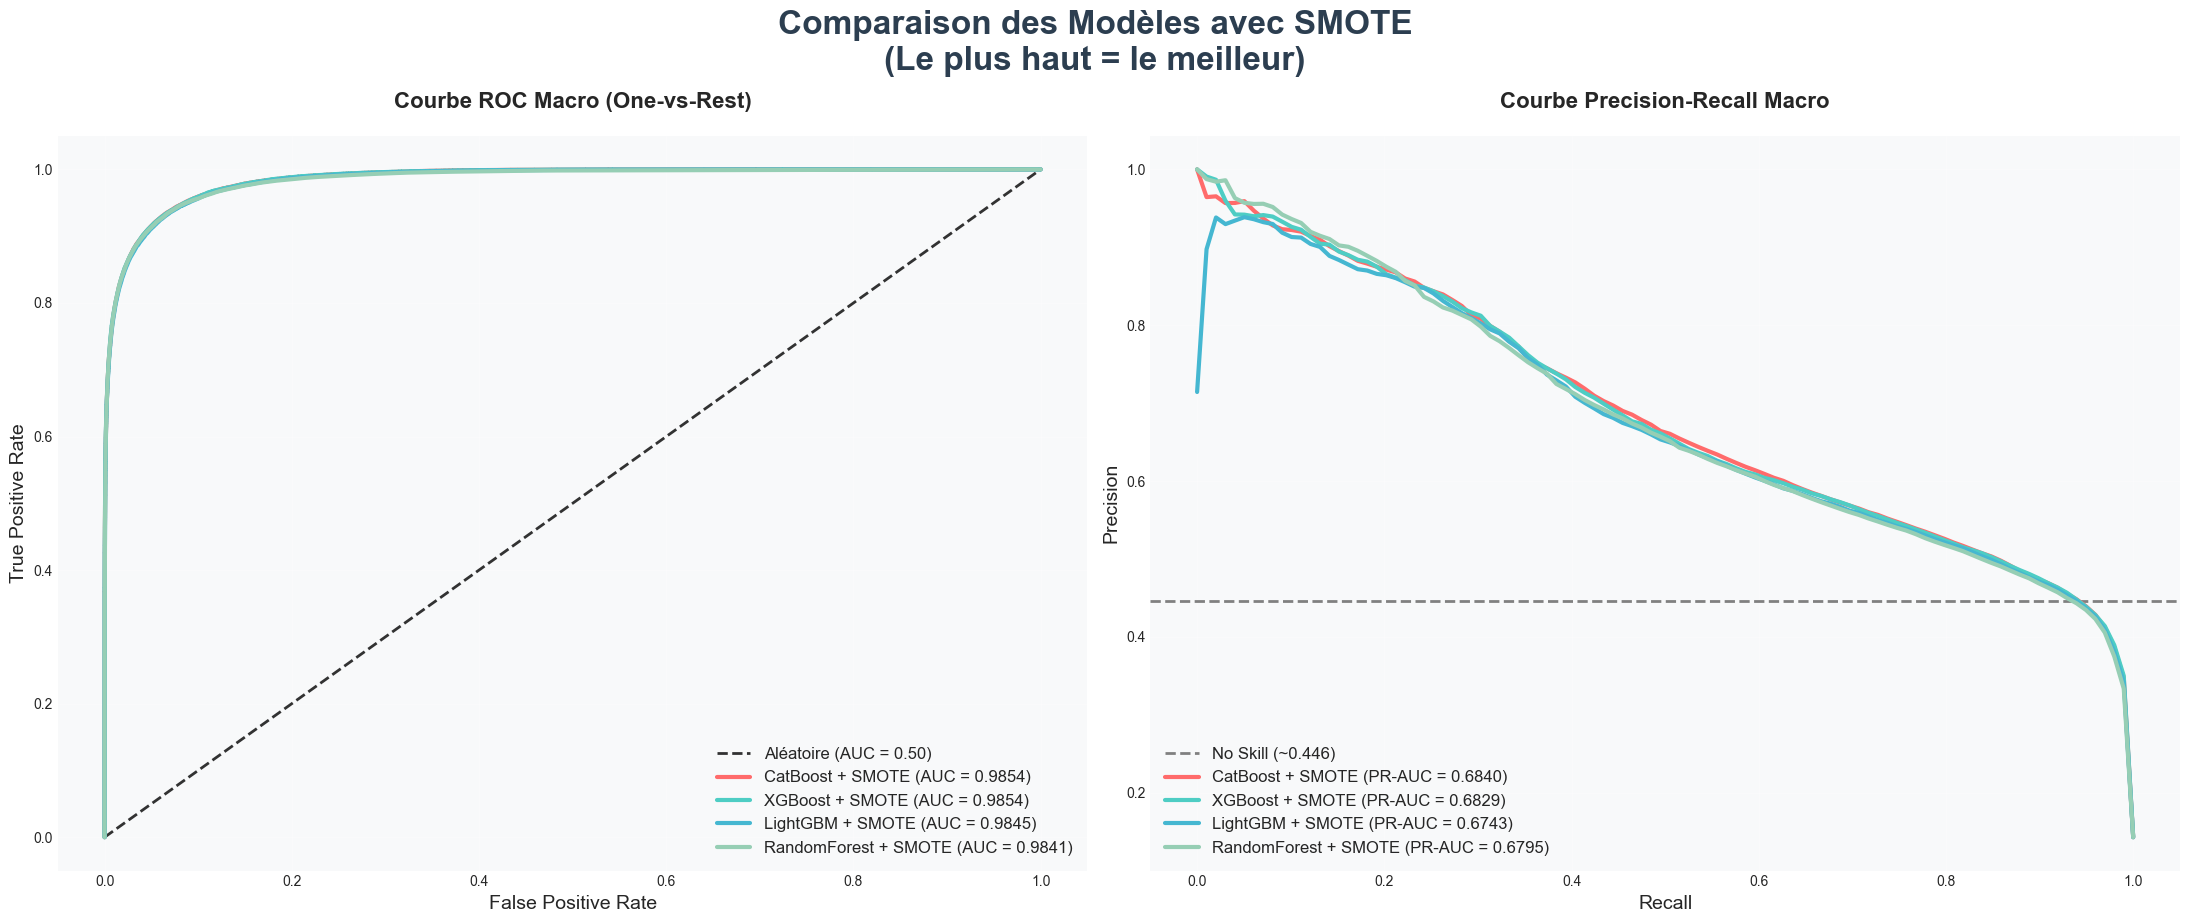

In [34]:
# ====================== 2. Courbes ROC & Precision-Recall (seulement SMOTE) ======================
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=range(n_classes))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))
fig.suptitle('Comparaison des Modèles avec SMOTE\n(Le plus haut = le meilleur)', 
             fontsize=24, fontweight='bold', color='#2c3e50', y=1.02)

# ROC
ax1.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.8, label='Aléatoire (AUC = 0.50)')

# Precision-Recall baseline
no_skill = sum(y_test == y_test.value_counts().idxmax()) / len(y_test)  # approx majorité
ax2.axhline(y=no_skill, color='gray', linestyle='--', lw=2, label=f'No Skill (~{no_skill:.3f})')

for idx, row in df_smote_only.iterrows():
    color = colors_smote[idx]
    name = row['Modèle']
    y_proba = row['y_proba']
    
    # ROC Macro
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, lw=3, color=color, 
             label=f'{name} (AUC = {roc_auc:.4f})')
    
    # Precision-Recall Macro (interpolation propre)
    precision, recall, _ = {}, {}, {}
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    
    all_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(all_recall)
    for i in range(n_classes):
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= n_classes
    pr_auc = auc(all_recall, mean_precision)
    
    ax2.plot(all_recall, mean_precision, lw=3, color=color,
             label=f'{name} (PR-AUC = {pr_auc:.4f})')

# Finalisation ROC
ax1.set_xlabel('False Positive Rate', fontsize=14)
ax1.set_ylabel('True Positive Rate', fontsize=14)
ax1.set_title('Courbe ROC Macro (One-vs-Rest)', fontsize=16, fontweight='bold', pad=20)
ax1.legend(fontsize=12, loc="lower right")
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#f8f9fa')

# Finalisation PR
ax2.set_xlabel('Recall', fontsize=14)
ax2.set_ylabel('Precision', fontsize=14)
ax2.set_title('Courbe Precision-Recall Macro', fontsize=16, fontweight='bold', pad=20)
ax2.legend(fontsize=12, loc="lower left")
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [41]:
from tabulate import tabulate
from colorama import Fore, Style, init
import pandas as pd

init(autoreset=True)

# ====================== Préparation des données ======================
df_all = pd.DataFrame(results)

# Colonnes utiles
df_compare = df_all[['Modèle', 'SMOTE', 'Temps (min)', 'Accuracy', 'F1-micro', 'ROC-AUC (macro)']].round(4)

# Tri par F1-macro décroissant
df_compare = df_compare.sort_values('F1-micro', ascending=False).reset_index(drop=True)

# Trouver les meilleurs scores pour coloration
best_accuracy = df_compare['Accuracy'].max()
best_f1 = df_compare['F1-micro'].max()
best_auc = df_compare['ROC-AUC (macro)'].max()

def color_best(value, best_value):
    return f"{Fore.GREEN}{Style.BRIGHT}{value}{Style.RESET_ALL}" if value == best_value else value

def rank_emoji(rank):
    if rank == 0:
        return "🥇 1er"
    elif rank == 1:
        return "🥈 2e"
    elif rank == 2:
        return "🥉 3e"
    else:
        return f"{rank+1}e"

# ====================== Préparation du tableau ======================
rows = []
for idx, row in df_compare.iterrows():
    smote_flag = f"{Fore.CYAN}{row['SMOTE']}{Style.RESET_ALL}" if row['SMOTE'] == "Oui" else row['SMOTE']
    rows.append([
        rank_emoji(idx),
        row['Modèle'],
        smote_flag,
        f"{row['Temps (min)']:.2f}",
        color_best(row['Accuracy'], best_accuracy),
        color_best(row['F1-micro'], best_f1),
        color_best(row['ROC-AUC (macro)'], best_auc),
    ])

# ====================== Affichage ======================
print("\n" + "="*100)
print(" COMPARAISON : Baseline vs SMOTE ".center(100))
print("="*100 + "\n")

print(tabulate(
    rows,
    headers=["Rang", "Modèle", "SMOTE", "Temps (min)", "Accuracy", "F1-micro", "ROC-AUC (macro)"],
    tablefmt="fancy_grid",
    floatfmt=".4f"
))

# ====================== Meilleur modèle global ======================
best_row = df_compare.iloc[0]
print("\n" + "-"*100)
print(f"MEILLEUR MODÈLE ACTUEL → {best_row['Modèle']} (SMOTE: {best_row['SMOTE']})")
print(f"F1-micro = {best_row['F1-micro']} | ROC-AUC = {best_row['ROC-AUC (macro)']} | Temps = {best_row['Temps (min)']} min")
print("-"*100 + "\n")



                                  COMPARAISON : Baseline vs SMOTE                                   

╒════════╤═══════════════════════════╤═════════╤═══════════════╤════════════╤════════════╤═══════════════════╕
│ Rang   │ Modèle                    │ SMOTE   │   Temps (min) │   Accuracy │   F1-micro │   ROC-AUC (macro) │
╞════════╪═══════════════════════════╪═════════╪═══════════════╪════════════╪════════════╪═══════════════════╡
│ 🥇 1er │ XGBoost                   │ Non     │        0.1400 │     0.8655 │     0.8655 │            0.9656 │
├────────┼───────────────────────────┼─────────┼───────────────┼────────────┼────────────┼───────────────────┤
│ 🥈 2e  │ RandomForest              │ Non     │        0.7400 │     0.8640 │     0.8640 │            0.9607 │
├────────┼───────────────────────────┼─────────┼───────────────┼────────────┼────────────┼───────────────────┤
│ 🥉 3e  │ CatBoost                  │ Non     │        1.7000 │     0.8634 │     0.8634 │            0.9654 │
├────────┼──

# fine tuning modéle baseline sans smote 

In [46]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

def objective_lgb(trial):
    # Hyperparamètres à tester
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    
    # Pipeline avec le preprocessor déjà défini
    pipe = Pipeline([
        ('prep', preprocessor),
        ('model', LGBMClassifier(**params))
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1  


In [48]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=7)  # nombre d'essais à ajuster selon ton temps



[I 2025-11-19 22:31:32,704] A new study created in memory with name: no-name-9c4e4a21-94c3-4705-9943-c5cddfa8e749
[I 2025-11-19 22:31:55,618] Trial 0 finished with value: 0.6542436346235423 and parameters: {'n_estimators': 209, 'max_depth': 10, 'learning_rate': 0.048287445720658295, 'num_leaves': 125, 'min_child_samples': 59, 'subsample': 0.6497524343013288, 'colsample_bytree': 0.6620798315846839}. Best is trial 0 with value: 0.6542436346235423.
[I 2025-11-19 22:32:31,602] Trial 1 finished with value: 0.6439405101624739 and parameters: {'n_estimators': 367, 'max_depth': 8, 'learning_rate': 0.012329304983239165, 'num_leaves': 101, 'min_child_samples': 81, 'subsample': 0.6654509619114987, 'colsample_bytree': 0.5349361442407167}. Best is trial 0 with value: 0.6542436346235423.
[I 2025-11-19 22:34:07,615] Trial 2 finished with value: 0.6605433556560362 and parameters: {'n_estimators': 980, 'max_depth': 9, 'learning_rate': 0.028357020370466897, 'num_leaves': 112, 'min_child_samples': 66, 's

In [49]:
best_params = study_lgb.best_params
print("Meilleurs hyperparamètres LightGBM:", best_params)

# On peut ré-entraîner avec ces params
pipe_lgb_tuned = Pipeline([
    ('prep', preprocessor),
    ('model', LGBMClassifier(**best_params))
])
pipe_lgb_tuned.fit(X_train, y_train)
y_pred = pipe_lgb_tuned.predict(X_test)
y_proba = pipe_lgb_tuned.predict_proba(X_test)
add_result("LightGBM (Tuned)", pipe_lgb_tuned, duration, y_pred, y_proba, smote=False, tuned=True)


Meilleurs hyperparamètres LightGBM: {'n_estimators': 820, 'max_depth': 8, 'learning_rate': 0.08925025633411898, 'num_leaves': 141, 'min_child_samples': 10, 'subsample': 0.7452936629618315, 'colsample_bytree': 0.8131162019553264}


In [53]:

# Créer le DataFrame complet
df_results = pd.DataFrame(results)

# Filtrer la ligne du modèle LightGBM Tuned
df_lgb_tuned = df_results[df_results['Modèle'] == 'LightGBM (Tuned)']

# Afficher proprement
display(df_lgb_tuned)


,Modèle,SMOTE,Tuned,Temps (s),Temps (min),Accuracy,F1-macro,F1-weighted,F1-micro,ROC-AUC (macro),model_object,y_pred,y_proba
9,LightGBM (Tuned),Non,Oui,240.36,4.01,0.8689,0.6609,0.8638,0.8689,0.9638,"(ColumnTransformer(remainder='passthrough',\n ...","[5, 0, 3, 5, 3, 4, 0, 4, 3, 1, 5, 3, 3, 1, 3, ...","[[0.013240822082165241, 0.06797429381145183, 0..."


In [55]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }
    pipe = Pipeline([('prep', preprocessor), ('model', XGBClassifier(**params))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')


In [57]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)  # nombre d'essais à ajuster selon ton temps



[I 2025-11-19 22:52:50,022] A new study created in memory with name: no-name-d7255bee-931f-44a0-8ac2-edc233093655
[I 2025-11-19 22:53:33,919] Trial 0 finished with value: 0.658018099873963 and parameters: {'n_estimators': 320, 'max_depth': 9, 'learning_rate': 0.28388524038485646, 'subsample': 0.7822323067632113, 'colsample_bytree': 0.7193736097388811}. Best is trial 0 with value: 0.658018099873963.
[I 2025-11-19 22:54:56,570] Trial 1 finished with value: 0.6569838633714117 and parameters: {'n_estimators': 782, 'max_depth': 7, 'learning_rate': 0.045134475316030494, 'subsample': 0.5043411517120457, 'colsample_bytree': 0.6362024727464606}. Best is trial 0 with value: 0.658018099873963.
[I 2025-11-19 22:55:27,198] Trial 2 finished with value: 0.6535358564444876 and parameters: {'n_estimators': 185, 'max_depth': 11, 'learning_rate': 0.051729023657697, 'subsample': 0.6150067156642458, 'colsample_bytree': 0.8472512131292418}. Best is trial 0 with value: 0.658018099873963.
[I 2025-11-19 22:55:

In [58]:
# Récupérer les meilleurs hyperparamètres XGBoost
best_params_xgb = study_xgb.best_params
print("Meilleurs hyperparamètres XGBoost:", best_params_xgb)

# Ré-entraîner le pipeline XGBoost avec ces hyperparamètres
pipe_xgb_tuned = Pipeline([
    ('prep', preprocessor),
    ('model', XGBClassifier(
        **best_params_xgb,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ))
])

start = time.time()
pipe_xgb_tuned.fit(X_train, y_train)
duration = time.time() - start

# Prédictions
y_pred = pipe_xgb_tuned.predict(X_test)
y_proba = pipe_xgb_tuned.predict_proba(X_test)

# Ajouter au tableau des résultats
add_result("XGBoost (Tuned)", pipe_xgb_tuned, duration, y_pred, y_proba, smote=False, tuned=True)

# Filtrer et afficher uniquement XGBoost Tuned
df_results = pd.DataFrame(results)
df_xgb_tuned = df_results[df_results['Modèle'] == 'XGBoost (Tuned)']
display(df_xgb_tuned[['Modèle','SMOTE','Tuned','Temps (min)','Accuracy','F1-macro','ROC-AUC (macro)']])


Meilleurs hyperparamètres XGBoost: {'n_estimators': 591, 'max_depth': 9, 'learning_rate': 0.1539402197771498, 'subsample': 0.9858662551323958, 'colsample_bytree': 0.7505164539717061}


,Modèle,SMOTE,Tuned,Temps (min),Accuracy,F1-macro,ROC-AUC (macro)
10,XGBoost (Tuned),Non,Oui,1.26,0.8694,0.6632,0.9651


In [60]:
df_xgb_tuned

,Modèle,SMOTE,Tuned,Temps (s),Temps (min),Accuracy,F1-macro,F1-weighted,F1-micro,ROC-AUC (macro),model_object,y_pred,y_proba
10,XGBoost (Tuned),Non,Oui,75.86,1.26,0.8694,0.6632,0.8643,0.8694,0.9651,"(ColumnTransformer(remainder='passthrough',\n ...","[5, 1, 3, 5, 3, 4, 0, 4, 3, 1, 5, 3, 3, 1, 3, ...","[[0.007565498, 0.06172352, 0.006764522, 0.0067..."


In [61]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'random_seed': 42,
        'verbose': 0
    }
    pipe = Pipeline([('prep', preprocessor), ('model', CatBoostClassifier(**params))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')


In [62]:
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=20)  # nombre d'essais à ajuster selon ton temps

[I 2025-11-19 23:21:48,275] A new study created in memory with name: no-name-78591bdb-81ae-4195-abc2-77eb62fd4d70
[I 2025-11-19 23:22:12,391] Trial 0 finished with value: 0.577073209749034 and parameters: {'iterations': 239, 'depth': 5, 'learning_rate': 0.03157753051854069}. Best is trial 0 with value: 0.577073209749034.
[I 2025-11-19 23:29:57,260] Trial 1 finished with value: 0.6507525333871722 and parameters: {'iterations': 979, 'depth': 10, 'learning_rate': 0.1601877463832616}. Best is trial 1 with value: 0.6507525333871722.
[I 2025-11-19 23:32:40,595] Trial 2 finished with value: 0.6497794603639423 and parameters: {'iterations': 833, 'depth': 7, 'learning_rate': 0.21040064792909566}. Best is trial 1 with value: 0.6507525333871722.
[I 2025-11-19 23:33:44,863] Trial 3 finished with value: 0.6335927291957911 and parameters: {'iterations': 730, 'depth': 5, 'learning_rate': 0.04625555058593899}. Best is trial 1 with value: 0.6507525333871722.
[I 2025-11-19 23:35:55,341] Trial 4 finished

In [ ]:
# Récupérer les meilleurs hyperparamètres CatBoost
best_params_cat = study_cat.best_params
print("Meilleurs hyperparamètres CatBoost:", best_params_cat)

# Ré-entraîner le pipeline CatBoost avec ces hyperparamètres
pipe_cat_tuned = Pipeline([
    ('prep', preprocessor),
    ('model', CatBoostClassifier(
        **best_params_cat,
        random_state=42,
        verbose=False,
        thread_count=-1
    ))
])

start = time.time()
pipe_cat_tuned.fit(X_train, y_train)
duration = time.time() - start

# Prédictions
y_pred = pipe_cat_tuned.predict(X_test)
y_proba = pipe_cat_tuned.predict_proba(X_test)

# Ajouter au tableau des résultats
add_result("CatBoost (Tuned)", pipe_cat_tuned, duration, y_pred, y_proba, smote=False, tuned=True)

# Filtrer et afficher uniquement CatBoost Tuned
df_results = pd.DataFrame(results)
df_cat_tuned = df_results[df_results['Modèle'] == 'CatBoost (Tuned)']
df_cat_tuned


Meilleurs hyperparamètres CatBoost: {'iterations': 999, 'depth': 10, 'learning_rate': 0.14063904939411329}
